# Moneyball Project: UEFA Euro 2020 Fantasy Football
Passion project to leverage data-driven decision making for team selection in [UEFA Euro 2020 Fantasy Football](https://gaming.uefa.com/en/uefaeuro2020fantasyfootball/overview)

## Modelling
-----------------------------
### Purpose
Project points and roi of player for quarter final of UEFA Euro 2020

### Author
[Christian Wibisono](https://github.com/christianwbsn)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline

import pulp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, precision_score
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from IPython.display import display

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row',50)

In [2]:
DATA_DIR = '../data'

In [3]:
data = pd.read_csv("{}/processed/dataset_md5.csv".format(DATA_DIR))

In [4]:
map_position = {
    "Daniel Bachmann": "GK",
    "Jack Grealish"  : "M",
    "Karim Benzema"  : "F",
    "Maarten Stekelenburg": "GK",
    "Aymeric Laporte": "D",
    "Rafa Silva": "M",
    "Gareth Bale": "M",
    "Joshua Kimmich": "M",
    "Federico Chiesa": "M"
}

In [5]:
data["position"] = data.apply(lambda x: map_position[x["player"]] if x["player"] in map_position.keys() else x["position"], axis=1)

In [6]:
data = data[data["position"] != "0"]

In [7]:
train = data[~pd.isnull(data["points"])]
train["roi"] = train["roi"].fillna(0)
test = data[pd.isnull(data["points"])]
test = test.drop_duplicates(subset=["player", "date"], keep="first")
test = test.reset_index(drop=True)

<ipython-input-7-3198189a0046>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["roi"] = train["roi"].fillna(0)


In [8]:
test = test[~pd.isnull(test["opponent_name"])]

In [9]:
eval_last_md = train[(train["league_name"] == "European Championship 2020") & (train["date"] >= "2021-06-25")]

In [10]:
eval_last_md = eval_last_md.sort_values(by=["points"], ascending=False)

In [11]:
eval_last_md[eval_last_md["position"] == "GK"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
4070,Jordan Pickford,2021-06-29 18:00:00,European Championship 2020,England,Germany,0.0,90.0,GK,2021.0,6.0,29.0,7.0,0.0,5.7,1.0,6.0,0.0,0.0,4.900000,0.0,0.0,7.0,2.078995,0.0,0.0,90.0,1.000000,10.0,0.0,0.0,0.700000,0.100000,1.0,30.0,NaN,NaN,NaN,6.000000,0.000000,6.0,3.0,0.0,0.333333,4.0,4.0,1686.0,1.0,12.0,1609.0,1.0,3.0,1.0,4.0,8.0,3.0,25.4,1.250000e+10,498000000.0,27.6,9.365000e+09,360200000.0,26.0,185.0,77.0,1.0,81.0,84.0,70000.0,1.0,NaN,NaN,NaN,NaN,NaN,GK,1.0,NaN,17.0,19.0,15.0,55.0,20.0,14.0,18.0,16.0,56.0,40.0,53.0,44.0,55.0,80.0,55.0,65.0,77.0,45.0,70.0,13.0,42.0,24.0,18.0,68.0,45.0,64.0,20.0,12.0,81.0,77.0,87.0,77.0,85.0,77.0,-8.0,3.135000e+09,137800000.0,-2.2,True,True,True,3.0,1.228070,False,Medium,Medium
8756,Thibaut Courtois,2021-06-27 21:00:00,European Championship 2020,Belgium,Portugal,0.0,90.0,GK,2021.0,6.0,27.0,7.0,0.0,6.2,1.0,6.0,0.0,0.0,4.714286,0.0,0.0,7.0,2.077086,0.0,0.0,90.0,1.000000,21.0,0.0,0.0,0.619048,0.000000,0.0,30.0,NaN,NaN,NaN,5.000000,1.732051,6.0,3.0,0.0,0.700000,1.0,1.0,1783.0,3.0,5.0,1666.0,0.0,1.0,1.0,1.0,2.0,1.0,29.2,6.694000e+09,257500000.0,27.9,8.725000e+09,335600000.0,28.0,199.0,96.0,1.0,89.0,90.0,250000.0,4.0,NaN,NaN,NaN,NaN,NaN,GK,1.0,NaN,14.0,14.0,13.0,33.0,12.0,13.0,19.0,20.0,35.0,23.0,42.0,52.0,61.0,84.0,45.0,56.0,68.0,38.0,70.0,17.0,23.0,15.0,13.0,44.0,27.0,66.0,18.0,16.0,84.0,89.0,74.0,85.0,88.0,117.0,-4.0,-2.031000e+09,-78100000.0,1.3,False,False,True,1.0,1.129032,False,Medium,Medium
4579,Kasper Schmeichel,2021-06-26 18:00:00,European Championship 2020,Denmark,Wales,0.0,90.0,GK,2021.0,6.0,26.0,6.0,0.0,5.0,1.0,2.0,0.0,0.0,4.074074,0.0,0.0,7.0,2.384661,0.0,0.0,90.0,0.962963,27.0,0.0,0.0,0.555556,0.185185,5.0,29.0,0.0,5.0,4.0,1.666667,0.577350,2.0,3.0,0.0,0.931034,9.0,10.0,1631.0,17.0,17.0,1570.0,2.0,0.0,0.0,4.0,1.0,2.0,27.7,3.107000e+09,119500000.0,25.6,1.767500e+09,68000000.0,33.0,189.0,89.0,1.0,84.0,84.0,90000.0,2.0,NaN,NaN,NaN,

In [12]:
eval_last_md[eval_last_md["position"] == "D"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
3839,Joakim Maehle,2021-06-26 18:00:00,European Championship 2020,Denmark,Wales,0.0,90.0,D,2021.0,6.0,26.0,12.0,1.0,4.7,2.0,8.0,1.0,0.0,5.800000,0.0,0.000000,12.0,4.494441,0.547723,0.000000,90.0,0.800000,5.0,0.400000,0.000000,0.400000,0.200000,1.0,29.0,NaN,NaN,NaN,3.666667,3.785939,8.0,3.0,0.333333,0.172414,9.0,10.0,1631.0,17.0,17.0,1570.0,2.0,0.0,0.0,4.0,1.0,2.0,27.7,3.107000e+09,119500000.0,25.6,1.767500e+09,68000000.0,23.0,184.0,79.0,1.0,76.0,81.0,13000.0,1.0,91.0,56.0,67.0,71.0,68.0,NaN,NaN,79.0,70.0,50.0,59.0,73.0,62.0,71.0,63.0,25.0,68.0,73.0,88.0,93.0,67.0,71.0,64.0,65.0,84.0,94.0,74.0,62.0,73.0,69.0,72.0,65.0,33.0,70.0,72.0,70.0,12.0,8.0,12.0,10.0,8.0,61.0,-7.0,1.339500e+09,51500000.0,2.1,False,False,False,5.0,2.553191,False,High,High
9105,Tomás Holes,2021-06-27 18:00:00,European Championship 2020,Czech Republic,Netherlands,0.0,90.0,D,2021.0,6.0,27.0,11.0,1.0,4.5,3.0,2.0,0.0,0.0,2.100000,0.0,0.000000,8.0,2.131770,0.316228,0.000000,76.5,0.700000,10.0,0.100000,0.000000,0.100000,0.100000,1.0,29.0,NaN,NaN,NaN,1.666667,0.577350,2.0,3.0,0.000000,0.344828,40.0,40.0,1458.0,12.0,16.0,1598.0,2.0,0.0,0.0,5.0,3.0,1.0,27.4,1.900000e+09,73100000.0,27.2,6.370500e+09,245000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-140.0,24.0,-4.470500e+09,-171900000.0,0.2,False,True,False,NaN,2.444444,False,NaN,NaN
6808,Oleksandr Zinchenko,2021-06-29 21:00:00,European Championship 2020,Ukraine,Sweden,0.0,90.0,D,2021.0,6.0,29.0,11.0,1.0,5.5,2.0,2.0,0.0,0.0,3.521739,0.0,0.086957,12.0,3.072896,0.344350,0.288104,90.0,0.826087,23.0,0.130435,0.086957,0.260870,0.173913,4.0,28.0,NaN,NaN,NaN,1.666667,0.577350,2.0,3.0,0.000000,0.821429,22.0,24.0,1514.0,13.0,18.0,1569.0,1.0,1.0,1.0,3.0,3.0,1.0,26.4,1.972000e+09,75800000.0,29.2,2.150500e+09,82700000.0,

In [13]:
eval_last_md[eval_last_md["position"] == "M"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
6428,Mislav Orsic,2021-06-28 18:00:00,European Championship 2020,Croatia,Spain,0.0,90.0,M,2021.0,6.0,28.0,10.0,1.0,6.5,3.0,0.0,0.0,0.0,1.300000,0.0,0.100000,5.0,1.567021,0.000000,0.316228,7.0,0.200000,10.0,0.000000,0.100000,0.100000,0.000000,0.0,28.0,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.357143,4.0,14.0,1605.0,6.0,6.0,1648.0,2.0,2.0,0.0,5.0,10.0,6.0,27.8,3.758000e+09,144500000.0,26.5,9.150000e+09,381300000.0,27.0,179.0,69.0,1.0,76.0,76.0,500.0,2.0,90.0,79.0,70.0,77.0,58.0,NaN,NaN,61.0,72.0,79.0,50.0,71.0,76.0,77.0,80.0,76.0,66.0,72.0,89.0,90.0,88.0,74.0,85.0,81.0,60.0,77.0,57.0,80.0,53.0,60.0,78.0,66.0,68.0,77.0,60.0,58.0,8.0,13.0,6.0,15.0,14.0,-43.0,8.0,-5.392000e+09,-236800000.0,1.3,False,True,True,0.0,1.538462,False,High,High
2726,Ferran Torres,2021-06-28 18:00:00,European Championship 2020,Spain,Croatia,0.0,90.0,M,2021.0,6.0,28.0,10.0,1.0,8.1,3.0,6.0,1.0,0.0,4.538462,0.0,0.000000,18.0,4.647856,0.877058,0.000000,88.0,0.692308,13.0,0.384615,0.000000,0.307692,0.230769,3.0,30.0,NaN,NaN,NaN,3.333333,2.516611,6.0,3.0,0.333333,0.433333,6.0,6.0,1648.0,4.0,14.0,1605.0,2.0,2.0,0.0,10.0,5.0,6.0,26.5,9.150000e+09,381300000.0,27.8,3.758000e+09,144500000.0,20.0,184.0,77.0,1.0,81.0,89.0,97000.0,1.0,82.0,76.0,78.0,80.0,34.0,SUB,20.0,64.0,77.0,77.0,70.0,80.0,72.0,82.0,71.0,48.0,78.0,79.0,88.0,77.0,80.0,76.0,68.0,76.0,75.0,73.0,66.0,75.0,45.0,34.0,77.0,86.0,66.0,82.0,24.0,28.0,12.0,9.0,11.0,15.0,12.0,43.0,-8.0,5.392000e+09,236800000.0,-1.3,False,True,True,8.0,1.234568,False,High,Medium
8880,Thorgan Hazard,2021-06-27 21:00:00,European Championship 2020,Belgium,Portugal,0.0,90.0,M,2021.0,6.0,27.0,9.0,1.0,8.1,3.0,0.0,0.0,0.0,3.739130,0.0,0.173913,12.0,2.831919,0.518435,0.387553,90.0,0.826087,23.0,0.173913,0.173913,0.478261,0.043478,1.0,30.0,NaN,NaN,NaN,3.000000,3.000000,6.0,2.0,0.333333,0.766667,1.0,1.0,1783.0,3.0,5.0,1666.0,0.0,1.0,1.0,1.0,2.0,1.0,29.2,6.694000e+09,257500000.0,2

In [14]:
eval_last_md[eval_last_md["position"] == "F"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
4550,Kasper Dolberg,2021-06-26 18:00:00,European Championship 2020,Denmark,Wales,0.0,90.0,F,2021.0,6.0,26.0,11.0,0.0,7.0,4.0,1.0,0.0,0.0,2.600000,0.0,0.050000,13.0,3.719083,0.732695,0.223607,51.0,0.550000,20.0,0.150000,0.050000,0.300000,0.100000,2.0,29.0,0.0,0.0,0.0,0.333333,0.577350,1.0,1.0,0.000000,0.689655,9.0,10.0,1631.0,17.0,17.0,1570.0,2.0,0.0,0.0,4.0,1.0,2.0,27.7,3.107000e+09,119500000.0,25.6,1.767500e+09,68000000.0,22.0,187.0,84.0,1.0,79.0,83.0,39000.0,2.0,73.0,81.0,69.0,77.0,29.0,ST,9.0,67.0,50.0,81.0,74.0,79.0,78.0,78.0,73.0,70.0,60.0,79.0,71.0,75.0,72.0,74.0,64.0,86.0,71.0,72.0,79.0,79.0,32.0,21.0,82.0,77.0,78.0,76.0,24.0,19.0,7.0,15.0,13.0,9.0,7.0,61.0,-7.0,1.339500e+09,51500000.0,2.1,False,False,False,4.0,1.571429,False,High,Medium
3292,Haris Seferovic,2021-06-28 21:00:00,European Championship 2020,Switzerland,France,0.0,90.0,F,2021.0,6.0,28.0,10.0,1.0,8.7,4.0,7.0,1.0,0.0,3.909091,0.0,0.090909,13.0,3.084664,0.738549,0.294245,89.5,0.818182,22.0,0.363636,0.090909,0.181818,0.136364,3.0,29.0,NaN,NaN,NaN,3.333333,3.214550,7.0,3.0,0.333333,0.758621,6.0,13.0,1606.0,1.0,2.0,1757.0,0.0,1.0,1.0,2.0,5.0,3.0,27.0,2.835000e+09,109000000.0,27.9,1.030000e+10,395400000.0,28.0,189.0,85.0,1.0,75.0,75.0,15000.0,2.0,70.0,74.0,65.0,70.0,47.0,RS,9.0,81.0,65.0,74.0,76.0,66.0,76.0,70.0,72.0,64.0,58.0,73.0,66.0,74.0,66.0,73.0,60.0,80.0,76.0,71.0,87.0,68.0,81.0,42.0,82.0,66.0,68.0,77.0,46.0,40.0,9.0,13.0,9.0,9.0,16.0,-151.0,11.0,-7.465000e+09,-286400000.0,-0.9,True,True,True,0.0,1.149425,False,High,Medium
4485,Karim Benzema,2021-06-28 21:00:00,European Championship 2020,France,Switzerland,0.0,90.0,F,2021.0,6.0,28.0,10.0,1.0,10.1,4.0,10.0,2.0,0.0,4.666667,0.0,0.000000,10.0,4.618802,1.154701,0.000000,90.0,1.000000,3.0,0.333333,0.000000,0.333333,0.333333,1.0,31.0,NaN,NaN,NaN,4.666667,4.618802,10.0,3.0,0.666667,0.096774,1.0,2.0,1757.0,6.0,13.0,1606.0,1.0,0.0,1.0,5.0,2.0,3.0,27.9,1.030000e+1

In [15]:
train.shape

(9128, 123)

In [16]:
test.shape

(191, 123)

In [17]:
train.head()

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
0,Aaron Ramsey,2018-09-06 00:00:00,UEFA Nations League,Wales,Republic of Ireland,21.00,90.0,M,2018.0,9.0,6.0,7.0,0.0,8.7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,19.0,1536.0,26.0,29.0,1484.0,0.0,2.0,2.0,0.0,4.0,3.0,25.6,1.767500e+09,68000000.0,25.5,7.765000e+08,29900000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,52.0,-10.0,9.910000e+08,38100000.0,0.1,True,True,False,1.0,0.804598,False,High,High
1,Aaron Ramsey,2018-09-09 00:00:00,UEFA Nations League,Wales,Denmark,13.50,90.0,M,2018.0,9.0,9.0,2.0,0.0,8.7,3.0,7.0,1.0,0.0,7.000000,1.0,0.0,7.0,0.000000,0.000000,0.0,90.0,1.0,1.0,1.000000,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,7.0,0.0,7.0,3.0,1.0,1.00,18.0,19.0,1536.0,9.0,9.0,1580.0,0.0,0.0,0.0,0.0,0.0,NaN,25.6,1.767500e+09,68000000.0,27.8,3.107000e+09,119500000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,-44.0,10.0,-1.339500e+09,-51500000.0,-2.2,True,True,False,1.0,0.229885,False,High,High
2,Aaron Ramsey,2018-10-11 00:00:00,International Friendlies,Wales,Spain,1.42,90.0,M,2018.0,10.0,11.0,2.0,0.0,8.7,3.0,2.0,0.0,0.0,4.500000,0.5,0.0,7.0,2.672612,0.534522,0.0,90.0,1.0,2.0,0.500000,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,2.0,0.0,2.0,3.0,0.0,1.00,18.0,19.0,1536.0,6.0,9.0,1597.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75

In [18]:
train.columns

Index(['player', 'date', 'league_name', 'team_name', 'opponent_name',
       'fantasy_points', 'min', 'position', 'year', 'month',
       ...
       'diff_team_mean_market_value', 'diff_team_mean_squad_age', 'is_senior',
       'is_imbalanced', 'big_match', 'gap_to_potential', 'roi',
       'more_likely_to_win', 'attacking_work_rate', 'defending_work_rate'],
      dtype='object', length=123)

In [19]:
def train_model(df, dropped_cols, label, model, need_fillna):
    train = df[df["league_name"] != "European Championship 2020"]
    test = df[df["league_name"] == "European Championship 2020"]
    X_train = pd.get_dummies(train.drop(dropped_cols, axis=1))
    X_test = pd.get_dummies(test.drop(dropped_cols, axis=1))
    if need_fillna:
        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)
    y_train = train[label]
    y_test  = test[label]
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    mae, mse = mean_absolute_error(y_test, prediction), mean_squared_error(y_test, prediction)
    print(model)
    print("MAE:", mae)
    print("MSE:", mse)

In [20]:
fifa_col = ['attacking_crossing','attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'height_cm', 'weight_kg',
            'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
            'movement_reactions', 'movement_balance', 'power_shot_power',
            'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
            'mentality_aggression', 'mentality_interceptions',
            'mentality_positioning', 'mentality_vision', 'mentality_penalties',
            'mentality_composure', 'defending_standing_tackle',
            'defending_sliding_tackle', 'goalkeeping_diving',
            'goalkeeping_handling', 'goalkeeping_kicking',
            'goalkeeping_positioning', 'goalkeeping_reflexes', 'attacking_finishing']

In [21]:
dropped_cols = ['player', 'league_name', 'date', 'year','points', 'is_star_of_match',
                'roi', 'value', 'min', 'nation_position', 'age', 'month', 'day',
                'nation_jersey_number','team_name', 'opponent_name', 'last_md_points',
                'fantasy_points', 'prev_median_min', "prev_std_goals",
                "prev_team_highest_rank" , "prev_opponent_highest_rank", 
                "is_senior", "hth_draw", 'last_md_goals', 'last_md_assists']

In [22]:
dropped_cols += fifa_col

Need to find sweet spot between player consistency and speculation (The Mavericks) --> player with high volatility of points [http://www.frontier-economics.com/uk/en/news-and-articles/articles/article-i7337-how-to-win-your-fantasy-football-league/] 
* roi -> measuring value for money (find undervalued player)
* points --> measuring player consistency

In [23]:
model_roi = RandomForestRegressor(random_state=1)
train_model(train, dropped_cols, "roi", model_roi, True)

RandomForestRegressor(random_state=1)
MAE: 0.42116022361605704
MSE: 0.24020320449956864


In [24]:
model_points = LGBMRegressor(random_state=1)
train_model(train, dropped_cols, "points", model_points, False)

LGBMRegressor(random_state=1)
MAE: 2.142578259277768
MSE: 6.552247736286028


## The Dream Team

In [25]:
X_test = pd.get_dummies(test.drop(dropped_cols, axis=1))

In [26]:
def plotImp(model, X , num =20, fig_size = (9, 3)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title(str(model) +' Features')
    plt.tight_layout()
    plt.show()

In [27]:
def get_model(df, dropped_cols, label, model, need_fillna):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    if need_fillna:
        X = X.fillna(0)
    y = df[label]
    model.fit(X, y)
    print(X.columns)
    plotImp(model,X, 10)
    return model

Index(['skill', 'prev_mean_points', 'prev_mean_goals', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_std_assists',
       'prev_ratio_starter', 'count_played', 'goal_consistency',
       'assist_consistency', 'clean_sheet_consistency',
       'star_of_match_consistency', 'star_of_match_count', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'last_three_match_mean_points',
       'last_three_match_std_points', 'last_three_match_max_points',
       'last_three_match_significant_min_play', 'last_three_match_goal_rate',
       'prev_ratio_played', 'team_rank', 'team_total_points', 'opponent_rank',
       'opponent_total_points', 'hth_team_win', 'hth_opp_win',
       'hth_team_score', 'hth_opp_score', 'htt_max_margin',
       'team_mean_squad_age', 'team_market_value', 'team_mean_market_value',
       'opponent_mean_squad_age', 'opponent_market_value',
       'opponent_mean_m

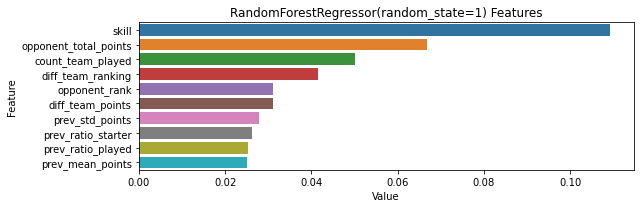

Index(['skill', 'prev_mean_points', 'prev_mean_goals', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_std_assists',
       'prev_ratio_starter', 'count_played', 'goal_consistency',
       'assist_consistency', 'clean_sheet_consistency',
       'star_of_match_consistency', 'star_of_match_count', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'last_three_match_mean_points',
       'last_three_match_std_points', 'last_three_match_max_points',
       'last_three_match_significant_min_play', 'last_three_match_goal_rate',
       'prev_ratio_played', 'team_rank', 'team_total_points', 'opponent_rank',
       'opponent_total_points', 'hth_team_win', 'hth_opp_win',
       'hth_team_score', 'hth_opp_score', 'htt_max_margin',
       'team_mean_squad_age', 'team_market_value', 'team_mean_market_value',
       'opponent_mean_squad_age', 'opponent_market_value',
       'opponent_mean_m

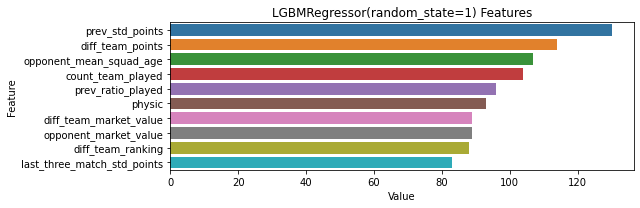

In [28]:
model_1 = get_model(train, dropped_cols, 'roi', model_roi, True)
model_2 = get_model(train, dropped_cols, 'points', model_points, False)

In [29]:
import shap
shap.initjs()

In [30]:
explainer = shap.Explainer(model_2)
shap_obj = explainer(X_test)

In [31]:
def player_to_watch(shap_obj, df, player_name):
    print("Evaluating points for: ", player_name)
    player = df[(df["player"] == player_name)][:1]
    display(player)
    shap.plots.waterfall(shap_obj[player.index[0]])

In [32]:
X_test

,skill,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_assists,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,team_rank,team_total_points,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,physic,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_imbalanced,big_match,gap_to_potential,more_likely_to_win,position_D,position_F,position_GK,position_M,attacking_work_rate_High,attacking_work_rate_Low,attacking_work_rate_Medium,defending_work_rate_High,defending_work_rate_Low,defending_work_rate_Medium
0,3.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4.0,0.000000,0.000000,1.000000,0.000000,0.0,31.0,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.129032,4.0,1686.0,24.0,1514.0,1.0,0.0,2.0,1.0,1.0,25.4,1.250000e+10,498000000.0,26.4,1.972000e+09,75800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.0,-20.0,1.052800e+10,422200000.0,-1.0,True,False,NaN,False,0,0,0,1,0,0,0,0,0,0
4,3.0,0.777778,0.0,0.000000,2.0,0.666667,0.000000,0.111111,9.0,0.000000,0.000000,0.333333,0.000000,0.0,31.0,0.0,1.0,1.0,0.333333,0.577350,1.0,1.0,0.000000,0.290323,6.0,1648.0,13.0,1606.0,1.0,1.0,3.0,3.0,1.0,26.5,9.150000e+09,381300000.0,27.0,2.835000e+09,109000000.0,1.0,79.0,85.0,80000.0,1.0,96.0,66.0,68.0,87.0,38.0,81.0,42.0,-7.0,6.315000e+09,272300000.0,-0.5,False,True,6.0,False,0,0,0,1,1,0,0,0,1,0
5,4.0,1.888889,0.0,0.055556,6.0,1.811366,0.235702,0.333333,18.0,0.166667,0.055556,0.055556,0.000000,0.0,30.0,0.0,2.0,1.5,0.666667,0.577350,1.0,2.0,0.000000,0.600000,13.0,1606.0,6.0,1648.0,1.0,1.0,3.0,3.0,1.0,27.0,2.835000e+09,109000000.0,26.5,9.150000e+09,381300000.0,1.0,76.0,76.0,45000.0,2.0,69.0,76.0,71.0,80.0,44.0,67.0,-42.0,7.0,-6.315000e+09,-272300000.0,0.5,False,True,0.0,False,0,1,0,0,0,0,1,1,0,0
13,1.0,0.200000,0.0,0.000000,1.0,0.447214,0.000000,0.200000,5.0,0.000000,0.000000,0.200000,0.000000,0.0,30.0,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.166667,40.0,1458.0,10.0,1631.0,0.0,1.0,1.0,4.0,3.0,27.4,1.900000e+09,73100000.0,27.7,3.107000e+09,119500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-173.0,30.0,-1.207000e+09,-46400000.0,-0.3,True,False,NaN,False,0,0,1,0,0,0,0,0,0,0
14,2.0,1.875000,0.0,0.000000,6.0,2.642374,0.000000,0.375000,8.0,0.000000,0.000000,0.375000,0.000000,0.0,30.0,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.266667,40.0,1458.0,10.0,1631.0,0.0,1.0,1.0,4.0,3.0,27.4,1.900000e+09,73100000.0,27.7,3.107000e+09,119500000.0,2.0,70.0,74.0,500.0,1.0,74.0,41.0,63.0,68.0,67.0,70.0,-173.0,30.0,-1.207000e+09,-46400000.0,-0.3,True,False,4.0,False,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,3.0,1.545455,0.0,0.090909,6.0,1.752920,0.301511,0.454545,11.0,0.000000,0.090909,0.090909,0.000000,0.0,29.0,NaN,NaN,NaN,0.333333,0.577350,1.0,1.0,0.000000,0.379310,24.0,1514.0,4.0,1686.0,0.0,1.0,1.0,2.0,1.0,26.4,1.972000e+09,75800000.0,25.4,1.250000e+10,498000000.0,1.0,70.0,70.0,8000.0,1.0,63.0,57.0,69.0,66.0,70.0,67.0,-172.0,20.0,-1.052800e+10,-422200000.0,1.0,True,False,0.0,False,1,0,0,0,0,0,1,0,0,1
552,3.0,3.321429,0.0,0.142857,11.

In [33]:
test["predicted_roi"] = model_1.predict(X_test.fillna(0))
test["predicted_points"] = model_2.predict(X_test)

## Surfacing The Result

In [34]:
injured = ["Christian Eriksen", "Ben Chilwell", "Dejan Lovren", "Ethan Ampadu", "Thomas Lemar", "Lucas Hernandez"]

In [35]:
fantasy_euro = pd.read_csv("{}/interim/fantasy_euro.csv".format(DATA_DIR))

In [36]:
fantasy_euro = fantasy_euro[["player", "date", "league_name", "team_name", 
                             "opponent_name", "value", "skill", "sel_per"]]

In [37]:
players = pd.merge(test, 
                   fantasy_euro[["player", "sel_per"]],
                   how='left', on="player")

In [38]:
players = players.drop_duplicates(subset=["player", "team_name"])

In [39]:
players["player"] = players["player"].apply(lambda x: re.sub("-", " ", x))

In [40]:
players = players[players['position'] != "0"]
players = players[~players['player'].isin(injured)]

In [41]:
players = players[players["prev_ratio_played"] > 0.1]

In [42]:
scaler = StandardScaler()
players["scaled_points"] = scaler.fit_transform(players["predicted_points"].values.reshape(-1,1))
players["scaled_roi"] = scaler.fit_transform(players["predicted_roi"].values.reshape(-1,1))

In [43]:
players["final_score"] = players["scaled_points"] * 0.8 + players["scaled_roi"] * 0.2

In [44]:
players = players.sort_values(by=["final_score"], ascending=False)

In [45]:
players["match"] = players["team_name"] + ',' + players['opponent_name']
players["match"] = players["match"].apply(lambda x: ' '.join(sorted(x.split(","))))

In [46]:
players["field"] = players["position"].apply(lambda x: "DEF" if x in ["GK", "D"] else "ATTACK")

In [47]:
col = ["player", "team_name", "opponent_name", "position", "value", "predicted_roi", "predicted_points", "final_score", "last_md_points", "prev_max_points", "prev_mean_points", "prev_std_points",'clean_sheet_consistency', 'sel_per']

In [48]:
views = players[col]

In [49]:
views.head(50)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
102,Kevin De Bruyne,Belgium,Italy,M,10.7,0.625310,4.964456,2.693459,1.0,17.0,6.562500,4.788441,0.500000,25
152,Raheem Sterling,England,Ukraine,M,9.7,0.618304,4.821586,2.585344,8.0,18.0,6.904762,4.968951,0.619048,14
73,Harry Kane,England,Ukraine,F,11.5,0.336249,5.145108,2.540639,6.0,17.0,5.111111,4.326424,0.518519,19
176,Thorgan Hazard,Belgium,Italy,M,8.1,0.676364,4.209455,2.207713,9.0,12.0,3.958333,2.970568,0.500000,5
94,Jordi Alba,Spain,Switzerland,D,6.2,0.528284,4.232253,2.079969,0.0,8.0,4.500000,2.718251,0.400000,18
172,Thibaut Courtois,Belgium,Italy,GK,6.2,0.826018,3.766170,2.038823,7.0,7.0,4.818182,2.084783,0.636364,21
62,Ferran Torres,Spain,Switzerland,M,8.1,0.526986,4.135746,2.010276,10.0,18.0,4.928571,4.698024,0.357143,8
93,Jordan Pickford,England,Ukraine,GK,5.7,0.752766,3.682997,1.908657,7.0,7.0,5.090909,2.071451,0.727273,11
114,Luke Shaw,England,Ukraine,D,6.1,0.731106,3.679365,1.885032,9.0,9.0,5.333333,3.669696,0.833333,11
88,Joakim Maehle,Denmark,Czech Republic,D,4.7,1.200031,3.032153,1.881818,12.0,12.0,6.833333,4.750439,0.333333,14


## Goalkeeper

In [50]:
views[views["position"] == "GK"]

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
172,Thibaut Courtois,Belgium,Italy,GK,6.2,0.826018,3.766170,2.038823,7.0,7.0,4.818182,2.084783,0.636364,21
93,Jordan Pickford,England,Ukraine,GK,5.7,0.752766,3.682997,1.908657,7.0,7.0,5.090909,2.071451,0.727273,11
184,Unai Simón,Spain,Switzerland,GK,5.2,0.465621,3.524132,1.516951,2.0,6.0,3.300000,1.888562,0.400000,5
101,Kasper Schmeichel,Denmark,Czech Republic,GK,5.0,0.603910,3.064122,1.325157,6.0,7.0,4.142857,2.368220,0.535714,14
67,Gianluigi Donnarumma,Italy,Belgium,GK,5.7,0.499902,2.644472,0.926509,2.0,7.0,4.913043,1.975142,0.695652,48
65,Georgi Bushchan,Ukraine,England,GK,4.9,0.604078,2.410176,0.861614,2.0,8.0,3.444444,2.743680,0.111111,1
190,Yann Sommer,Switzerland,Spain,GK,5.0,0.411780,2.068250,0.432277,2.0,14.0,3.760000,2.989983,0.280000,2
182,Tomás Vaclik,Czech Republic,Denmark,GK,5.1,0.388413,1.756144,0.188256,6.0,8.0,3.650000,2.183069,0.250000,1
40,David de Gea,Spain,Switzerland,GK,5.5,0.124741,1.690610,-0.114458,0.0,6.0,2.625000,2.334524,0.437500,3
16,Andriy Pyatov,Ukraine,England,GK,5.0,0.033126,0.999725,-0.693391,0.0,8.0,3.684211,2.769930,0.368421,0


Evaluating points for:  Gianluigi Donnarumma


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
177,Gianluigi Donnarumma,2021-07-02 21:00:00,European Championship 2020,Italy,Belgium,NaN,NaN,GK,2021.0,7.0,2.0,NaN,NaN,5.7,1.0,2.0,0.0,0.0,4.913043,0.0,0.0,7.0,1.975142,0.0,0.0,90.0,1.0,23.0,0.0,0.0,0.695652,0.173913,4.0,31.0,NaN,NaN,NaN,4.666667,2.309401,6.0,3.0,0.0,0.741935,7.0,7.0,1642.0,1.0,1.0,1783.0,1.0,1.0,0.0,3.0,3.0,2.0,27.8,7.640000e+09,293800000.0,29.2,6.694000e+09,257500000.0,21.0,196.0,90.0,1.0,85.0,92.0,34000.0,3.0,NaN,NaN,NaN,NaN,NaN,GK,21.0,NaN,12.0,12.0,12.0,34.0,8.0,28.0,12.0,14.0,24.0,28.0,46.0,54.0,64.0,79.0,38.0,57.0,72.0,34.0,72.0,18.0,30.0,26.0,14.0,50.0,24.0,68.0,14.0,16.0,89.0,81.0,76.0,83.0,89.0,-141.0,6.0,946000000.0,36300000.0,-1.4,False,False,True,7.0,NaN,False,Medium,Medium,0.499902,2.644472


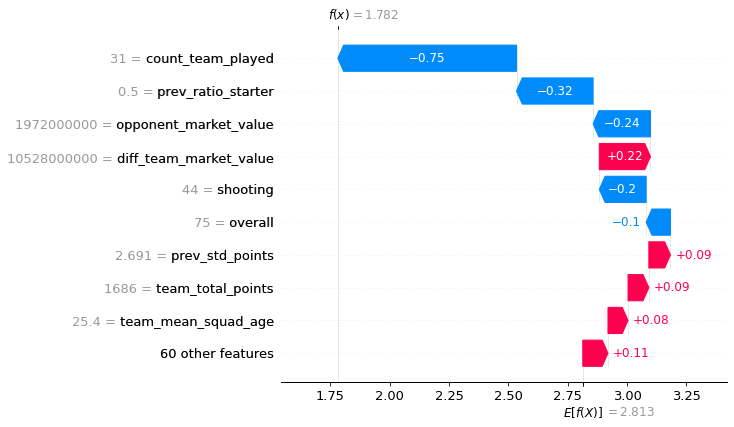

In [51]:
player_to_watch(shap_obj, test, "Gianluigi Donnarumma")

## Defender

In [52]:
views[(views["position"] == "D")].head(20)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
94,Jordi Alba,Spain,Switzerland,D,6.2,0.528284,4.232253,2.079969,0.0,8.0,4.500000,2.718251,0.400000,18
114,Luke Shaw,England,Ukraine,D,6.1,0.731106,3.679365,1.885032,9.0,9.0,5.333333,3.669696,0.833333,11
88,Joakim Maehle,Denmark,Czech Republic,D,4.7,1.200031,3.032153,1.881818,12.0,12.0,6.833333,4.750439,0.333333,14
74,Harry Maguire,England,Ukraine,D,5.5,0.695793,3.521582,1.738832,5.0,12.0,4.041667,3.316352,0.625000,3
106,Kyle Walker,England,Ukraine,D,5.5,0.645621,3.548711,1.709309,6.0,9.0,3.473684,2.524731,0.526316,11
174,Thomas Meunier,Belgium,Italy,D,5.7,0.599755,3.398072,1.557919,9.0,15.0,5.100000,4.140938,0.550000,24
83,Jan Vertonghen,Belgium,Italy,D,5.6,0.743463,3.139901,1.514512,6.0,6.0,4.318182,2.317354,0.681818,2
89,John Stones,England,Ukraine,D,5.7,0.737481,3.115738,1.491566,6.0,6.0,3.923077,2.465142,0.538462,17
178,Toby Alderweireld,Belgium,Italy,D,5.6,0.650910,2.688050,1.104165,5.0,12.0,4.250000,3.215990,0.535714,3
145,Pau Torres,Spain,Switzerland,D,4.7,0.575131,2.745078,1.070957,3.0,7.0,4.090909,2.165851,0.545455,22


## Midfielder

In [53]:
views[(views["position"] == "M")].head(30)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
102,Kevin De Bruyne,Belgium,Italy,M,10.7,0.625310,4.964456,2.693459,1.0,17.0,6.562500,4.788441,0.500000,25
152,Raheem Sterling,England,Ukraine,M,9.7,0.618304,4.821586,2.585344,8.0,18.0,6.904762,4.968951,0.619048,14
176,Thorgan Hazard,Belgium,Italy,M,8.1,0.676364,4.209455,2.207713,9.0,12.0,3.958333,2.970568,0.500000,5
62,Ferran Torres,Spain,Switzerland,M,8.1,0.526986,4.135746,2.010276,10.0,18.0,4.928571,4.698024,0.357143,8
17,Andriy Yarmolenko,Ukraine,England,M,8.7,0.435022,4.020775,1.839378,4.0,10.0,4.000000,2.958040,0.235294,7
131,Mikkel Damsgaard,Denmark,Czech Republic,M,6.1,0.706828,3.311226,1.600394,6.0,19.0,6.666667,6.801961,0.333333,4
77,Jack Grealish,England,Ukraine,M,7.6,0.402858,3.644964,1.541636,4.0,6.0,2.750000,2.753785,1.000000,7
52,Eden Hazard,Belgium,Italy,M,10.1,0.364358,3.537459,1.427990,3.0,15.0,5.722222,3.877621,0.555556,1
21,Axel Witsel,Belgium,Italy,M,5.4,0.446299,2.588062,0.834416,3.0,7.0,2.444444,1.423427,0.555556,1
173,Thomas Delaney,Denmark,Czech Republic,M,5.5,0.387024,2.544052,0.745604,3.0,9.0,2.760000,1.854724,0.440000,1


## Forward

In [54]:
views[views["position"] == "F"].head(20)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
73,Harry Kane,England,Ukraine,F,11.5,0.336249,5.145108,2.540639,6.0,17.0,5.111111,4.326424,0.518519,19
159,Romelu Lukaku,Belgium,Italy,F,11.3,0.353928,4.052918,1.783360,2.0,13.0,6.900000,3.416677,0.500000,53
158,Roman Yaremchuk,Ukraine,England,F,7.5,0.337708,3.535074,1.400400,2.0,9.0,3.480000,2.311565,0.280000,4
122,Martin Braithwaite,Denmark,Czech Republic,F,7.5,0.438113,3.032318,1.141477,6.0,6.0,3.142857,1.757825,0.428571,1
144,Patrik Schick,Czech Republic,Denmark,F,8.6,0.371490,3.092743,1.119578,6.0,12.0,4.666667,3.865382,0.222222,10
196,Álvaro Morata,Spain,Switzerland,F,9.1,0.404920,3.004458,1.089465,6.0,10.0,3.350000,2.680829,0.400000,5
72,Haris Seferovic,Switzerland,Spain,F,8.7,0.445152,2.899665,1.054256,10.0,13.0,4.173913,3.270421,0.173913,1
194,Yussuf Poulsen,Denmark,Czech Republic,F,8.4,0.488401,2.479761,0.798536,0.0,6.0,2.720000,1.744515,0.400000,3
25,Breel Embolo,Switzerland,Spain,F,8.1,0.333977,2.644812,0.765498,2.0,6.0,3.235294,1.921243,0.235294,1
19,Artem Besedin,Ukraine,England,F,5.9,0.690972,1.875078,0.566628,1.0,5.0,1.500000,1.760682,0.000000,0


## Selecting the Team

In [55]:
players = players.reset_index(drop=True)

In [56]:
def make_decision_variables(player_df):
    return [pulp.LpVariable(i, cat="Binary") for i in player_df.player]

In [57]:
def make_optimization_function(player_df, decision_variables):
    op_func = ""

    for i, player in enumerate(decision_variables):
        op_func += player_df.final_score[i]*player
        
    return op_func

In [58]:
def make_cash_constraint(player_df, decision_variables, available_cash):
    total_paid = ""
    for rownum, row in player_df.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                total_paid += row.value*player

    return (total_paid <= available_cash)

In [59]:
def make_player_constraint(position, n, decision_variables, player_df):
    
    total_n = ""
    
    player_positions = player_df.position
    
    for i, player in enumerate(decision_variables):
        if player_positions[i] == position:
            total_n += 1*player
            
    return(total_n == n)

In [60]:
def add_team_constraint(prob, player_df, decision_variables):

    for team, group in player_df.groupby('team_name'):
        team_total = ''
        for player in decision_variables:
            if re.sub("_", " ", player.name) in group.player.values:
                formula = 1*player
                team_total += formula

        prob += (team_total <= 4)

In [61]:
def add_match_constraint(prob, player_df, decision_variables):

    for team, group in player_df.groupby('match'):
        team_total = ''
        for player in decision_variables:
            if re.sub("_", " ", player.name) in group.player.values:
                formula = 1*player
                team_total += formula

        prob += (team_total <= 4)

In [62]:
available_cash = 105

prob = pulp.LpProblem('InitialTeam', pulp.LpMaximize)

decision_variables = make_decision_variables(players)
prob += make_optimization_function(players, decision_variables)
prob += make_cash_constraint(players, decision_variables, available_cash)
prob += make_player_constraint("GK", 2, decision_variables, players) 
prob += make_player_constraint("D", 5, decision_variables, players) 
prob += make_player_constraint("M", 5, decision_variables, players) 
prob += make_player_constraint("F", 3, decision_variables, players)
add_team_constraint(prob, players, decision_variables)
add_match_constraint(prob, players, decision_variables)

In [63]:
prob.writeLP('InitialTeam.lp')
optimization_result = prob.solve()

In [64]:
def get_initial_team(prob, player_df):
    
    variable_names = [re.sub("_", " ", v.name) for v in prob.variables()]
    variable_values = [v.varValue for v in prob.variables()]
    
    initial_team = pd.merge(pd.DataFrame({'player': variable_names,
                                          'selected': variable_values}),
                                           player_df, on="player")
    
    initial_team = initial_team[initial_team.selected==1.0] 
    
    return initial_team

In [65]:
initial_team_df = get_initial_team(prob, players)
initial_team_df[['player', "position", "value", "team_name", "predicted_points"]].sort_values("position")

,player,position,value,team_name,predicted_points
67,Harry Maguire,D,5.5,England,3.521582
81,Joakim Maehle,D,4.7,Denmark,3.032153
87,Jordi Alba,D,6.2,Spain,4.232253
107,Luke Shaw,D,6.1,England,3.679365
166,Thomas Meunier,D,5.7,Belgium,3.398072
66,Harry Kane,F,11.5,England,5.145108
115,Martin Braithwaite,F,7.5,Denmark,3.032318
150,Roman Yaremchuk,F,7.5,Ukraine,3.535074
164,Thibaut Courtois,GK,6.2,Belgium,3.766170
176,Unai Simón,GK,5.2,Spain,3.524132


In [66]:
initial_team_df["value"].sum()

104.6

In [67]:
initial_team_df["predicted_points"].sum()

56.03116130653354